In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table
from glob import glob

import stan_utils as stan
from mpl_utils import (mpl_style, common_limits)

plt.style.use(mpl_style)

np.random.seed(42)

%matplotlib inline

In [2]:
survey_data_paths = glob("data/*.csv")
survey_references = [each.split("/")[1].split("-")[0] for each in survey_data_paths]
survey_data = [Table.read(dp) for dp in survey_data_paths]

In [3]:
for dp, d in zip(survey_data_paths, survey_data):
    print(dp, d.dtype.names)

data/Adibekyan12-all-renorm.csv ('HIP', 'Star', 'Teff', 'logg', 'FeH', 'NaH', 'MgH', 'AlH', 'SiH', 'CaH', 'ScIH', 'ScIIH', 'TiIH', 'TiIIH', 'VH', 'CrIH', 'CrIIH', 'MnH', 'CoH', 'NiH')
data/Bensby14-all-renorm.csv ('HIP', 'Teff', 'logg', 'FeH', 'OH', 'NaH', 'MgH', 'AlH', 'SiH', 'CaH', 'TiH', 'CrH', 'NiH', 'ZnH', 'YH', 'BaH')
data/Valenti05-all-renorm.csv ('HIP', 'HD', 'Teff', 'logg', 'NaH', 'SiH', 'TiH', 'FeH', 'NiH')


In [4]:
label_identifier = "HIP"
label_names = ("Teff", "logg", "FeH", "SiH")
latex_label_names = [
    r"$T_{\rm eff}$ $(\textrm{K})$",
    r"$\log{g}$",
    r"\textrm{[Fe/H]}",
    r"\textrm{[Si/H]}",
]

In [5]:
# generate the data arrays
unique_hip_names = np.sort(np.unique(np.hstack([d["HIP"] for d in survey_data])))
N = unique_hip_names.size
M = len(survey_data)
D = len(label_names)

y = np.nan * np.ones((N, M, D), dtype=float)

In [6]:
for m, data in enumerate(survey_data):
    for i, star in enumerate(data):
        n = np.where(star[label_identifier] == unique_hip_names)[0][0]
        y[n, m, :] = np.array([(star[ln] if ln in star.dtype.names else np.nan) \
                               for ln in label_names])
        

In [7]:
# The [Si/H] in Bensby is actually [Si/Fe]......
if "SiH" in label_names and "data/Bensby14-all-renorm.csv" in survey_data_paths:
    si_index = list(label_names).index("SiH")
    fe_index = list(label_names).index("FeH")
    bensby_index = list(survey_data_paths).index("data/Bensby14-all-renorm.csv")
    # [Si/Fe] = [Si/H] - [Fe/H]
    y[:, bensby_index, si_index] = y[:, bensby_index, si_index] \
                                 + y[:, bensby_index, fe_index]

In [8]:
# set bad abundances as nans
for d, label_name in enumerate(label_names):
    if label_name not in ("Teff", "logg"):
        y[:, :, d][(y[:, :, d] >= 50)] = np.nan


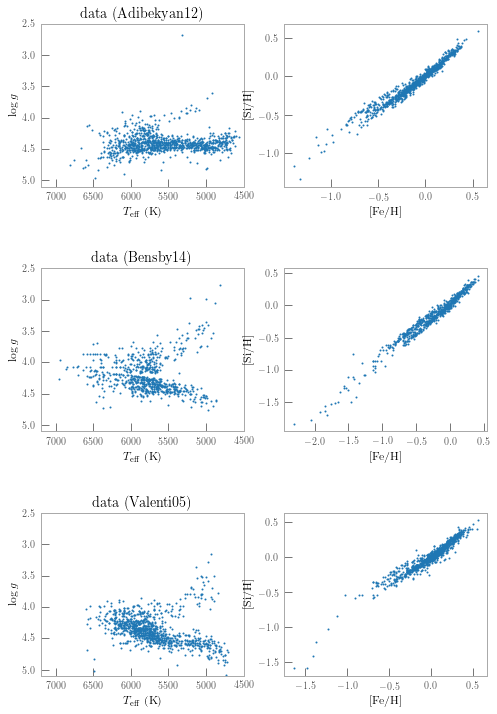

In [9]:
# PLOT ALL THE DATA

fig, axes = plt.subplots(M, 2, figsize=(4 * 2, 4 * M))
axes = np.array(axes)

xi, yi, xxi, yyi = range(4)
for m in range(M):
    ax_data, ax_data2 = axes[m]
    
    ax_data.scatter(y[:, m, xi],
                    y[:, m, yi],
                    s=1)
    
    ax_data2.scatter(y[:, m, xxi],
                     y[:, m, yyi],
                     s=1)
    
    survey_reference = survey_data_paths[m].split("/")[1].split("-")[0]
    
    ax_data.set_title(r"\textrm{{data ({0})}}".format(
                      survey_reference))
    
    ax_data.set_xlim(7200, 4500)
    ax_data.set_ylim(5.1, 2.5)
    
    ax_data.set_xlabel(latex_label_names[xi])
    ax_data.set_ylabel(latex_label_names[yi])
    
    ax_data2.set_xlabel(latex_label_names[xxi])
    ax_data2.set_ylabel(latex_label_names[yyi])
    

In [10]:
# checks
for d, label_name in enumerate(label_names):
    _ = y[:, :, d]
    print("{0}: ({1:.1f} to {2:.1f}), mean/median/std: {3:.1f}/{4:.1f}/{5:.1f} ({6:.0f} finite)".format(
          label_name, np.nanmin(_), np.nanmax(_), 
          np.nanmean(_), np.nanmedian(_), np.nanstd(_),
          np.sum(np.isfinite(_))))

Teff: (4556.0 to 7212.0), mean/median/std: 5668.1/5726.0/423.7 (2716 finite)
logg: (2.7 to 5.1), mean/median/std: 4.3/4.4/0.2 (2716 finite)
FeH: (-2.6 to 0.6), mean/median/std: -0.1/-0.1/0.3 (2716 finite)
SiH: (-1.8 to 0.6), mean/median/std: -0.1/-0.0/0.3 (2712 finite)


In [11]:
# Create an additive variance array to account for missing data.
def de_gapify_data(y, additional_variance=1e8):
    """
    Fill NaNs in the label vectors with the mean values of other
    labels. No structure is assumed for the missing labels (e.g.,
    some labels could be missing from some surveys, but not all).
    
    :param y:
        The label vector, where NaNs represent missing data.
    
    :param additional_variance: [optional]
        The variance to add for missing data.
    """
    
    N, M, D = y.shape
    missing = ~np.isfinite(y)
    label_means = np.nanmean(y.reshape((-1, D)), axis=0)
    label_scales = np.nanstd(y.reshape((-1, D)), axis=0)
    
    y_tilde = (np.copy(y) - label_means)/label_scales
    y_tilde[missing] = 0.0
    
    extra_variance = missing.astype(int) * additional_variance

    return (y_tilde, label_means, label_scales, extra_variance)

y_tilde, label_means, label_scales, extra_variance = de_gapify_data(y)

In [12]:
print(label_means)
print(label_scales)

[ 5.66809205e+03  4.33914212e+00 -1.16973490e-01 -7.41342183e-02]
[4.23715747e+02 2.31873573e-01 3.36219300e-01 2.76122628e-01]


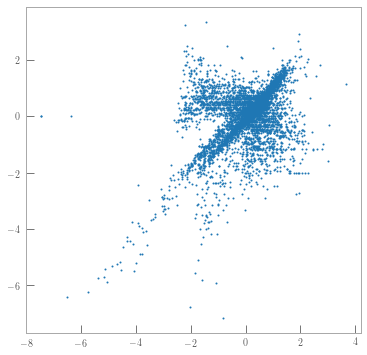

In [13]:
fig, ax = plt.subplots(figsize=(6, 6))
y_ = y_tilde.reshape((-1, 2))
ax.scatter(y_[:, 0], y_[:, 1], s=1)

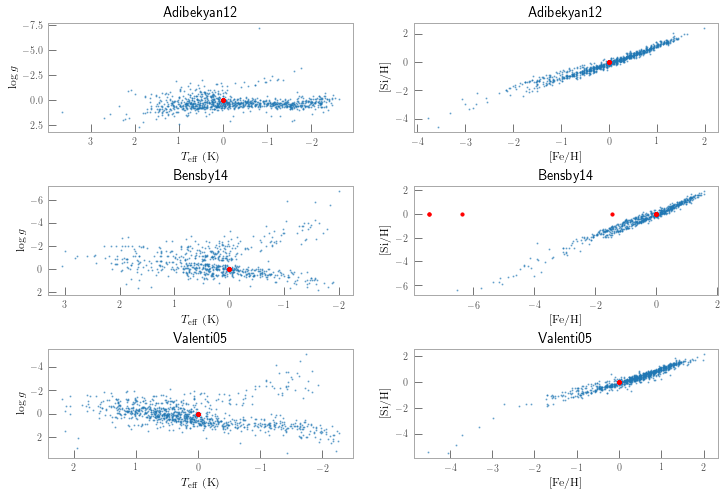

In [14]:
# Plot the data.

fig, axes = plt.subplots(M, 2, figsize=(M * 4, 8))
    
kwds = dict(s=1, alpha=0.5)
missing_kwds = kwds.copy()
missing_kwds.update(c="r", s=10, alpha=1, zorder=10)

for m, jaxes in enumerate(axes):
    
    ax, xa = jaxes
    
    x_, y_ = (y_tilde[:, m, 0], y_tilde[:, m, 1])
    missing = (x_ == 0) + (y_ == 0)
    
    ax.scatter(x_, y_, **kwds)
    ax.scatter(x_[missing], y_[missing], **missing_kwds)
    
    ax.set_xlabel(latex_label_names[0])
    ax.set_ylabel(latex_label_names[1])
    ax.set_xlim(ax.get_xlim()[::-1])
    ax.set_ylim(ax.get_ylim()[::-1])


    x_, y_ = (y_tilde[:, m, 2], y_tilde[:, m, 3])
    missing = (x_ == 0) + (y_ == 0)
    xa.scatter(x_, y_, **kwds)
    xa.scatter(x_[missing], y_[missing], **missing_kwds)

    xa.set_xlabel(latex_label_names[2])
    xa.set_ylabel(latex_label_names[3])
    
    for _ in (ax, xa):
        _.set_title(survey_references[m])
        

In [15]:
model = stan.read_model("model-missing-data.stan")
print(model.model_code)

INFO:root:Using pre-compiled model from model-missing-data.stan.cached



/*
  Latent factor model for chemical abundances from multiple studies, allowing
  for missing data.
*/

data {
  int<lower=1> N; // number of stars
  int<lower=1> D; // dimensionality of the data (number of labels)
  int<lower=1> M; // number of surveys (or studies)
  vector[D] y[N, M]; // the labels as reported by various surveys.
  vector[D] extra_variance[N, M]; // variance to add for missing data.
}

transformed data {
  int<lower=1> Q; // the number of non-zero lower-triangular entries that we
                  // need for the decomposoition of our theta matrix
  Q = M * choose(D, 2);
}

parameters {
  vector[D] X[N]; // latent factors for each star
  vector<lower=0>[M] phi[D]; // variance on survey labels

  vector[Q] L_lower_triangular; // lower triangular entries of the decomposition
                                // of the  theta matrix
  vector<lower=0, upper=2>[M] L_diag[D]; // diagonal entries of the decomposition of the 
                                        // theta 

In [20]:
# Optimize the model.
data = dict(N=N, M=M, D=D, y=y_tilde, 
            extra_variance=extra_variance)

Q = M * int(np.math.factorial(D)/(2 * np.math.factorial(D - 2)))
init = dict(
    X=np.random.normal(0, 1, size=(N, D)),
    phi=np.ones((D, M)),
    L_lower_triangular=np.zeros(Q),
    L_diag=np.ones((D, M)))

strict = False
op_kwds = dict(data=data, init=init, iter=10000)

if strict:
    op_kwds.update(
        init=init,
        iter=100000, 
        tol_obj=7./3 - 4./3 - 1, # machine precision
        tol_grad=7./3 - 4./3 - 1, # machine precision
        tol_rel_grad=1e3,
        tol_rel_obj=1e4
    )




In [21]:
p_opt = model.optimizing(**op_kwds)

/Users/arc/anaconda2/envs/py3/lib/python3.6/site-packages/pystan/misc.py:362: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(np.asarray(v).dtype, int):
/Users/arc/anaconda2/envs/py3/lib/python3.6/site-packages/pystan/misc.py:364: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


In [18]:
print(p_opt)

OrderedDict([('X', array([[ 0.01862683, -0.00512953,  0.02506865,  0.05876318],
       [ 0.38246801, -0.63206467, -0.8196439 , -0.73399472],
       [-0.13372525, -0.96194125,  0.51438775,  0.69788241],
       ...,
       [-0.03754269,  0.08687405,  0.01851674, -0.0059652 ],
       [ 0.05421762,  0.07097082, -0.00573095,  0.01321175],
       [-0.03817816, -0.00538006, -0.00813214,  0.00651912]])), ('phi', array([[1.26180530e+00, 7.33017973e-05, 8.51109405e-01],
       [5.20119449e-01, 1.27067239e-07, 1.00380557e+00],
       [6.53884229e-01, 2.23038015e-07, 6.97944829e-01],
       [7.65230572e-01, 2.20660391e-07, 6.82350551e-01]])), ('L_lower_triangular', array([-2.77359339e-04, -3.74265901e-04,  2.43301172e-04,  1.03022645e-04,
        1.86106134e-05,  7.96169534e-05, -1.33649067e-02,  1.66501876e-03,
       -1.31572618e-02,  3.94981910e-02,  2.40036111e-02,  2.33451078e-01,
       -3.02175610e-04, -7.95418566e-04,  6.69983872e-04,  3.78455900e-04,
       -3.34632198e-04, -7.64358011e-0

(2237, 3, 4)
0
1


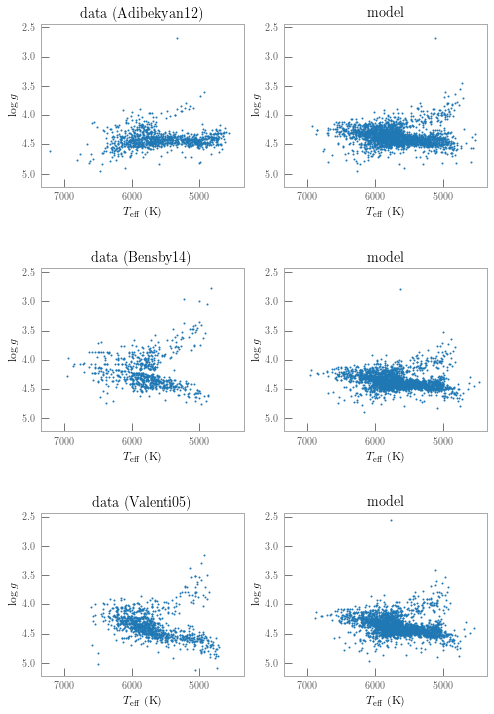

In [22]:
#  Plot model predictions compared to the data.
xi, yi = range(2) # indices to plot.

fig, axes = plt.subplots(M, 2, figsize=(4 * 2, 4 * M))
axes = np.array(axes)

print(y.shape)
print(xi)
print(yi)
for m in range(M):
    ax_data, ax_model = axes[m]
    
    ax_data.scatter(y[:, m, xi],
                    y[:, m, yi],
                    s=1)
    
    y_tilde_ = np.dot(p_opt["X"], p_opt["theta"][m]) * label_scales + label_means
    ax_model.scatter(y_tilde_[:, xi],
                     y_tilde_[:, yi],
                     s=1)
    
    survey_reference = survey_data_paths[m].split("/")[1].split("-")[0]
    
    ax_model.set_title(r"\textrm{model}")
    ax_data.set_title(r"\textrm{{data ({0})}}".format(
                      survey_reference))
    
xlim = np.hstack([ax.get_xlim() for ax in axes.flatten()])
ylim = np.hstack([ax.get_ylim() for ax in axes.flatten()])
xlim = (np.max(xlim), np.min(xlim))
ylim = (np.max(ylim), np.min(ylim))

for ax in axes.flatten():
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

    ax.set_xlabel(latex_label_names[xi])
    ax.set_ylabel(latex_label_names[yi])

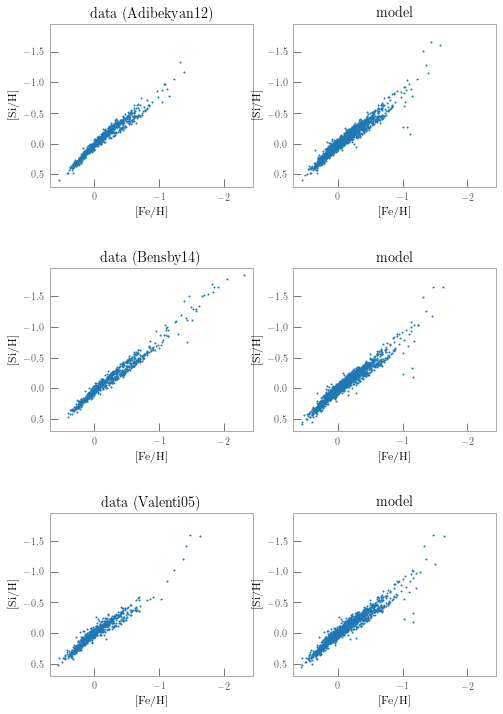

In [23]:
#  Plot model predictions compared to the data.
xi, yi = 2, 3 # indices to plot.

fig, axes = plt.subplots(M, 2, figsize=(4 * 2, 4 * M))
axes = np.array(axes)

for m in range(M):
    ax_data, ax_model = axes[m]
    
    ax_data.scatter(y[:, m, xi],
                    y[:, m, yi],
                    s=1)
    
    y_tilde_ = np.dot(p_opt["X"], p_opt["theta"][m]) * label_scales + label_means
    ax_model.scatter(y_tilde_[:, xi],
                     y_tilde_[:, yi],
                     s=1)
    
    survey_reference = survey_data_paths[m].split("/")[1].split("-")[0]
    
    ax_model.set_title(r"\textrm{model}")
    ax_data.set_title(r"\textrm{{data ({0})}}".format(
                      survey_reference))
    
xlim = np.hstack([ax.get_xlim() for ax in axes.flatten()])
ylim = np.hstack([ax.get_ylim() for ax in axes.flatten()])
xlim = (np.max(xlim), np.min(xlim))
ylim = (np.max(ylim), np.min(ylim))

for ax in axes.flatten():
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

    ax.set_xlabel(latex_label_names[xi])
    ax.set_ylabel(latex_label_names[yi])

{'vmin': -2.62, 'vmax': 0.56, 's': 1, 'cmap': 'viridis'}


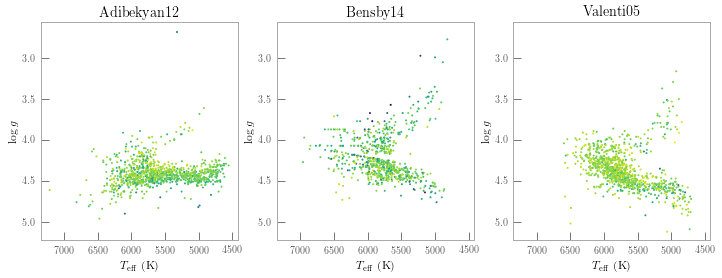

In [24]:
# Plot the H-R diagram of labels from various surveys, and the inferred latent variables
xi, yi, zi = range(3)

X = p_opt["X"] * label_scales + label_means

z = np.hstack([y[:, :, zi].flatten(), X[:, zi].flatten()])
kwds = dict(vmin=np.nanmin(z), vmax=np.nanmax(z),
            s=1, cmap="viridis")
kwds.update(vmin=np.nanmin(y[:, :, zi].flatten()),
            vmax=np.nanmax(y[:, :, zi].flatten()))
print(kwds)
K = M
fig, axes = plt.subplots(1, K, figsize=(4 * K, 4))

for m, ax in enumerate(axes[:M]):
    ax.scatter(y[:, m, xi], y[:, m, yi], c=y[:, m, zi],
               **kwds)
    
    ax.set_xlabel(latex_label_names[xi])
    ax.set_ylabel(latex_label_names[yi])
    
    survey_reference = survey_data_paths[m].split("/")[1].split("-")[0]
    ax.set_title(r"\textrm{{{0}}}".format(survey_reference))

xlim = np.hstack([ax.get_xlim() for ax in axes[:M]])
ylim = np.hstack([ax.get_ylim() for ax in axes[:M]])
xlim = (np.max(xlim), np.min(xlim))
ylim = (np.max(ylim), np.min(ylim))

    

#ax = axes[-1]
#ax.scatter(X[:, xi], X[:, yi], c=X[:, zi], **kwds)
#ax.set_title(r"\textrm{latent variables}")

for ax in axes:
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.set_xlabel(latex_label_names[xi])
    ax.set_ylabel(latex_label_names[yi])


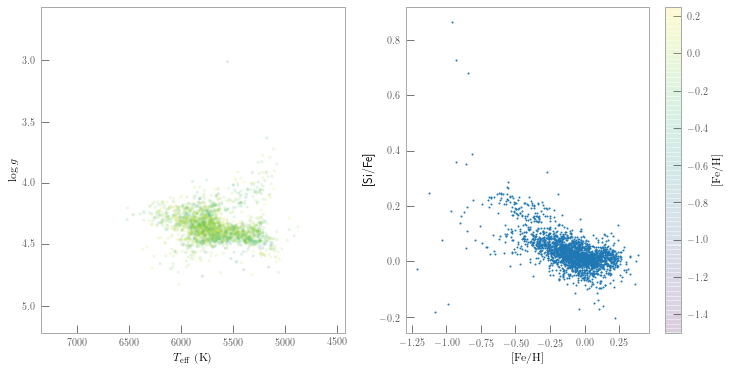

In [31]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

kwds.update(s=5, alpha=0.1, vmin=-1.5, vmax=0.25)

scat = axes[0].scatter(X[:, xi], X[:, yi], c=X[:, zi], **kwds)
axes[1].scatter(X[:, 2], X[:, 3] - X[:,2], s=1)

axes[1].set_xlabel(latex_label_names[2])
axes[1].set_ylabel(r"[Si/Fe]")

cbar = plt.colorbar(scat)
cbar.set_label(latex_label_names[zi])

ax = axes[0]
ax.set_xlim(xlim)
ax.set_ylim(ylim)
ax.set_xlabel(latex_label_names[xi])
ax.set_ylabel(latex_label_names[yi])

{'cmap': 'viridis', 'edgecolors': '#000000', 'linewidths': 0.5, 'vmin': -0.14885071402255923, 'vmax': 1.5584944431570564}


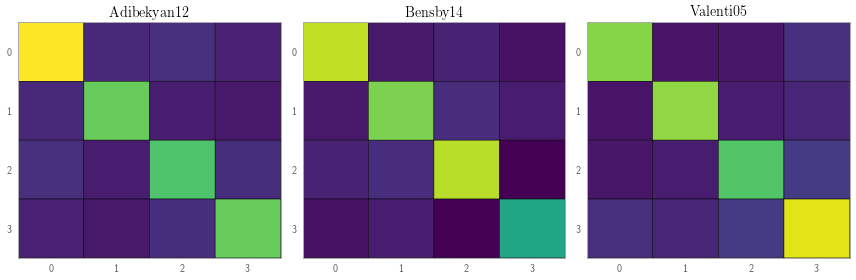

In [47]:
# Plot the theta coefficients for each survey.
fig, axes = plt.subplots(1, M, figsize=(4 * M, 4))

theta = p_opt["theta"]

kwds = dict(cmap="viridis", edgecolors="#000000", linewidths=0.5,
            vmin=np.min(theta), vmax=np.max(theta))

for m, ax in enumerate(axes):
    pcol = ax.pcolor(p_opt["theta"][m].T, **kwds)
    
    survey_reference = survey_data_paths[m].split("/")[1].split("-")[0]
    ax.set_title(r"\textrm{{{0}}}".format(survey_reference))
    ax.set_xticks(0.5 + np.arange(D))
    ax.set_yticks(0.5 + np.arange(D))
    ax.set_xticklabels(range(D))
    ax.set_yticklabels(range(D))
    
    ax.set_ylim(ax.get_ylim()[::-1])
        
fig.tight_layout()
print(kwds)

{'cmap': 'viridis', 'edgecolors': '#000000', 'linewidths': 0.5, 'vmin': 0, 'vmax': 2}


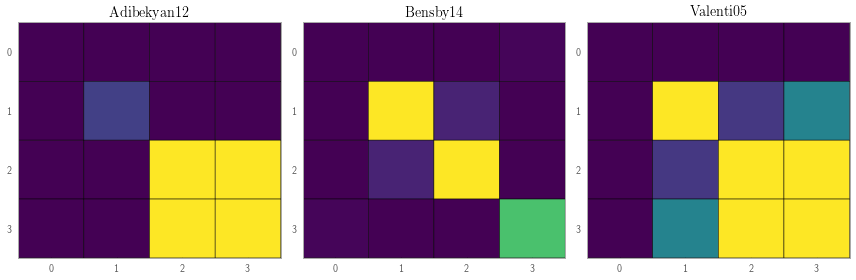

In [28]:
# Plot the theta coefficients for each survey.
fig, axes = plt.subplots(1, M, figsize=(4 * M, 4))

theta = p_opt["theta"]

kwds = dict(cmap="viridis", edgecolors="#000000", linewidths=0.5,
            vmin=0, vmax=2)

for m, ax in enumerate(axes):
    pcol = ax.pcolor(p_opt["theta"][m].T, **kwds)
    
    survey_reference = survey_data_paths[m].split("/")[1].split("-")[0]
    ax.set_title(r"\textrm{{{0}}}".format(survey_reference))
    ax.set_xticks(0.5 + np.arange(D))
    ax.set_yticks(0.5 + np.arange(D))
    ax.set_xticklabels(range(D))
    ax.set_yticklabels(range(D))
    
    ax.set_ylim(ax.get_ylim()[::-1])
        
fig.tight_layout()
print(kwds)

In [29]:
p_opt.keys()

odict_keys(['X', 'phi', 'L_lower_triangular', 'L_diag', 'L', 'theta'])

(array([5., 1., 1., 0., 1., 0., 0., 2., 1., 1.]),
 array([1.45198548e-08, 1.03980816e-01, 2.07961618e-01, 3.11942419e-01,
        4.15923221e-01, 5.19904022e-01, 6.23884824e-01, 7.27865625e-01,
        8.31846427e-01, 9.35827228e-01, 1.03980803e+00]),
 <a list of 10 Patch objects>)

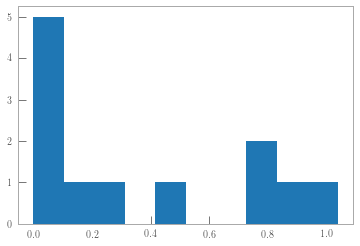

In [30]:
fig, ax  = plt.subplots()
ax.hist(p_opt["phi"].flatten())

(array([4., 5., 0., 0., 3., 1., 2., 1., 0., 2.]),
 array([-1.66011029, -1.29290671, -0.92570313, -0.55849955, -0.19129597,
         0.17590761,  0.54311118,  0.91031476,  1.27751834,  1.64472192,
         2.0119255 ]),
 <a list of 10 Patch objects>)

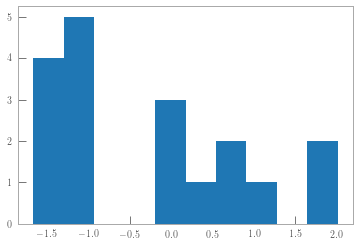

In [34]:
fig, ax = plt.subplots()
ax.hist(p_opt["L_lower_triangular"])

(array([ 4.,  4., 26.,  2.,  1.,  7.,  1.,  2.,  0.,  1.]),
 array([-1.71286009, -0.97778093, -0.24270177,  0.4923774 ,  1.22745656,
         1.96253572,  2.69761489,  3.43269405,  4.16777322,  4.90285238,
         5.63793154]),
 <a list of 10 Patch objects>)

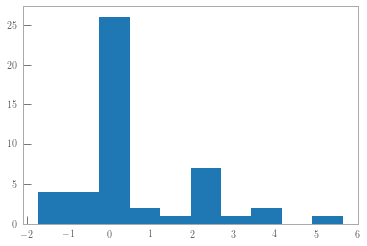

In [33]:
fig, ax = plt.subplots()
ax.hist(p_opt["theta"].flatten())

In [ ]:
np.diag(p_opt["theta"][2]).max()
#print(label_names)
#vmax

In [ ]:
print(p_opt["L"][0])

In [ ]:
# Plot the \sigma values for each survey.
